# 🚈 Exploration 19 Main Project : Segmentation Map 활용 🚈

## 🎯 루브릭 살펴보기 🎯

|루브릭 평가항목|세부기준|
|------|---|
|pix2pix 모델 학습을 위해 필요한 적절한 데이터셋 구축|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정 제시|
|구현한 pix2pix 모델의 학습 과정이 성공적으로 진행|U-Net generator, discriminator 모델 구현을 기반으로 train_step이 안정적으로 진행|
|학습 과정 및 테스트에 대한 시각화|최소 10epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질 증명|

## ❗ 사전 안내 ❗

- 이번 노드는 작업기간이 촉박한 상황에서 진행되었음을 감안하여 빠르게 진행하도록 하겠습니다.
- 루브릭을 최대한 모두 만족시키면서 얻은 주요 결과를 중심으로 회고를 작성하게 될 것입니다.

## 1. 데이터 준비

- Cloud Shell에서 아래 명령어를 입력하여 프로젝트에 사용할 zip 파일의 압축을 해제

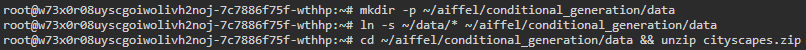

## 2. 필요 라이브러리

In [1]:
import tensorflow as tf

import os
import time
import cv2
import numpy as np

from glob import glob
from matplotlib import pyplot as plt
import matplotlib.image as image
from IPython import display

## 3. 데이터 살펴보기

- 학습 데이터, 검증 데이터 각각의 샘플 수를 확인

In [2]:
# 학습 데이터 샘플 수
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


In [3]:
# 검증 데이터 샘플 수
import os

data_path2 = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'
print("number of val examples :", len(os.listdir(data_path2)))

number of val examples : 5


- 각각의 이미지들이 어떻게 생겼는지 확인하기 위해 학습 데이터셋에서 임의로 6장을 시각화

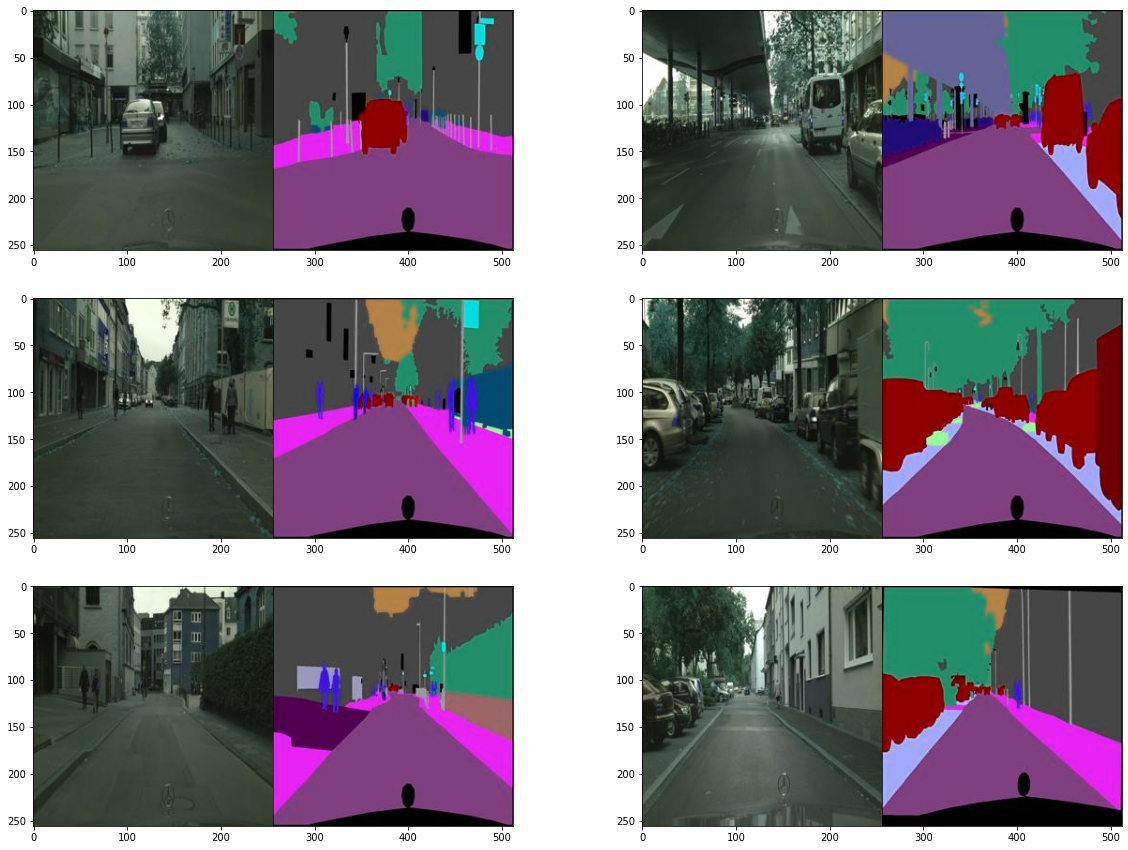

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 이 중에 하나의 이미지를 열고 크기를 확인
- **256×512 RGB 이미지**이다.

In [5]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 모델 학습에 사용할 데이터를 **2개의 256×256 RGB 이미지**로 나누는 코드
- 돌려봤더니, 일단 채색된 색깔로 대충 객체별로 구분이 잘 되어 있는 것 같다.
- 딥핑크 색깔은 사람, 나무는 녹색, 차량은 짙은 파란색으로 인식된 듯 하다.

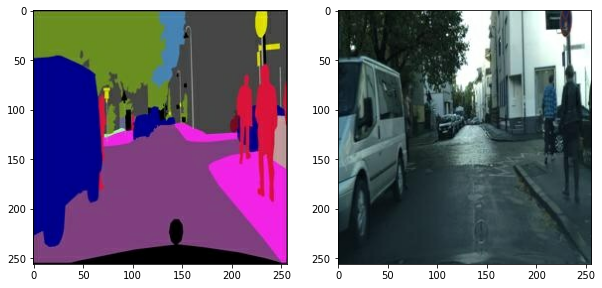

In [6]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

f = data_path + os.listdir(data_path)[1]
input_image, real_image = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(real_image))

- **학습에 사용할 수 있는 데이터가 1000개**이다. 다만 학습 데이터의 다양성을 높이고자 여러 augmentation 방법을 적용한다.

In [7]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(input_image, real_image):
    stacked = tf.concat([input_image, real_image], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

- 앞에서 구성한 함수를 데이터에 적용하고 시각화한다.
- 시각화된 결과를 요약해보면, **회전변환 및 이미지 축소(Image 6)**가 적용된 것으로 보인다.
- 이 외의 다양한 방법을 추가로 활용해볼 수 있다면, 더욱 다양한 종류의 데이터셋을 만들어 좋은 일반화를 만들어낼 수 있다.

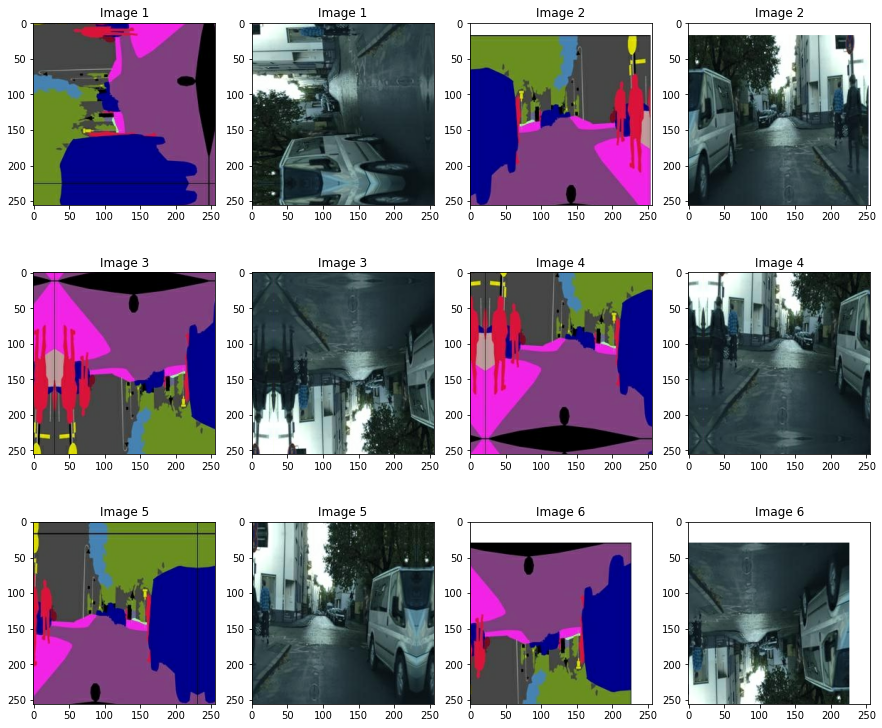

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_input, augmented_real = apply_augmentation(input_image, real_image)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_input)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

- 지금까지의 과정들을 학습 데이터에 적용한다.
- 잘 적용되었는지 확인하기 위해 하나의 이미지를 시각화하여 확인해 본다.

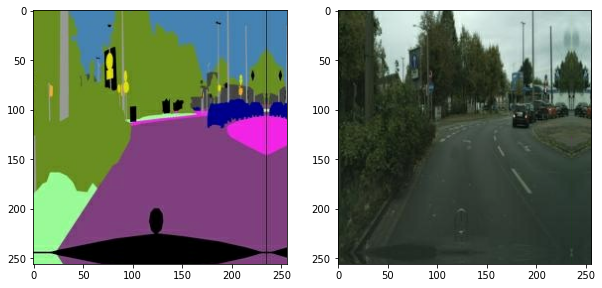

In [9]:
from tensorflow import data

def get_train(img_path):
    input_image, real_image = load_img(img_path)
    input_image, real_image = apply_augmentation(input_image, real_image)
    return input_image, real_image

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
input_image, real_image = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(input_image[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_image[0].astype(np.uint8))

## 4. Generator (생성자)

- 루브릭을 모두 만족하면서 진행하기 위해서 노드에서 소개된 **U-Net Generator**를 사용한다.
- **U-Net Generator**는 인코더와 디코더 사이를 skip connection으로 연결한 모델구조이다.
- Encoder에는 (256, 256, 3) 이미지를 입력으로 받고, 각 블록을 통과할수록 width, height 크기가 절반이 되고, 필터의 수는 늘어난다.
- Encoder는 최종 (1, 1, 512)의 크기로 출력된다.
- Decoder는 Encoder의 출력 이미지를 입력으로 받고, 각 블록을 통과할수록 width, height 크기가 2배로 늘어나고 필터의 수는 줄어든다.
- Decoder는 최종 (256, 256, 3)의 크기로 출력된다.

- 인코딩 블록과 디코딩 블록은 각각 여러 개의 함수로 구성된 클래스로 처리한다.

In [10]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

- 위에서 살펴본 클래스를 활용하여 U-Net Generator 모델을 구현한다.

In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- U-Net Generator 모델구성 요약

In [12]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 5. Discriminator (판별자)

- Discriminator에 사용할 블록을 클래스로 구성한다.

In [13]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

- 판별자 구현

In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # for loop로 간편하게 블록 만들기
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

- Discriminator 모델구성 요약

In [15]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

- 임의의 (256, 256, 3) 크기의 입력을 넣어 나오는 출력결과를 시각화

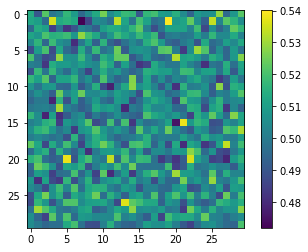

In [16]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 6. 모델 학습 및 테스트

- 이전 스텝에서 구성한 생성자, 판별자 모델에 대한 손실 함수 정의

In [17]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

- 최적화 함수 정의

In [18]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

- Tensorflow에서의 빠른 연산 작업을 위해 **@tf.function을 사용하여 train_step을 정의**한다.

In [19]:
@tf.function
def train_step(input_image, real_image):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        gen_output = generator(input_image, training=True)
        # Discriminator 예측
        fake_disc = discriminator(input_image, gen_output, training=True)
        real_disc = discriminator(input_image, real_image, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(gen_output, real_image, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

- 이제 모델을 학습시켜 본다.
- 캠퍼스 교육생분들의 epoch 효율 관련한 의견을 수용하여 적당히 100 epoch만 진행해 보겠다.

In [20]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (input_image, real_image) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(input_image, real_image)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
        
        # 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:1.1708                     
L1_loss:0.2384                     
Discriminator_loss:0.6835

EPOCH[1] - STEP[200]                     
Generator_loss:1.8563                     
L1_loss:0.1726                     
Discriminator_loss:0.6786

EPOCH[2] - STEP[100]                     
Generator_loss:1.3207                     
L1_loss:0.1677                     
Discriminator_loss:0.7932

EPOCH[2] - STEP[200]                     
Generator_loss:2.2541                     
L1_loss:0.1565                     
Discriminator_loss:0.6208

EPOCH[3] - STEP[100]                     
Generator_loss:2.4650                     
L1_loss:0.1693                     
Discriminator_loss:1.0069

EPOCH[3] - STEP[200]                     
Generator_loss:0.8522                     
L1_loss:0.1701                     
Discriminator_loss:1.2393

EPOCH[4] - STEP[100]                     
Generator_loss:1.1541                     
L1_loss:0.1970             

- 각 epoch에 따른 학습결과 시각화

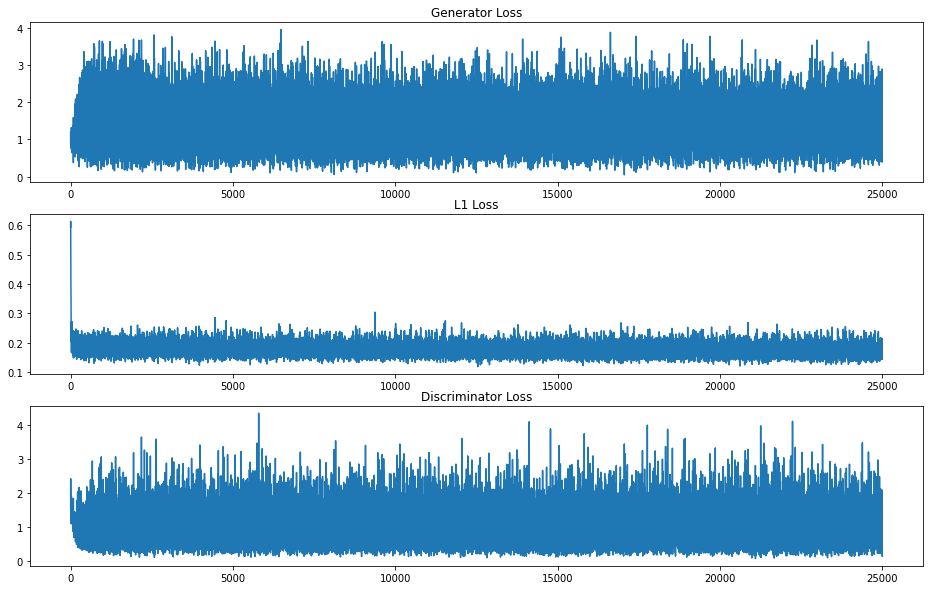

In [21]:
plt.figure(figsize=(16,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

- 최종 테스트 결과는 다음과 같게 나왔다.

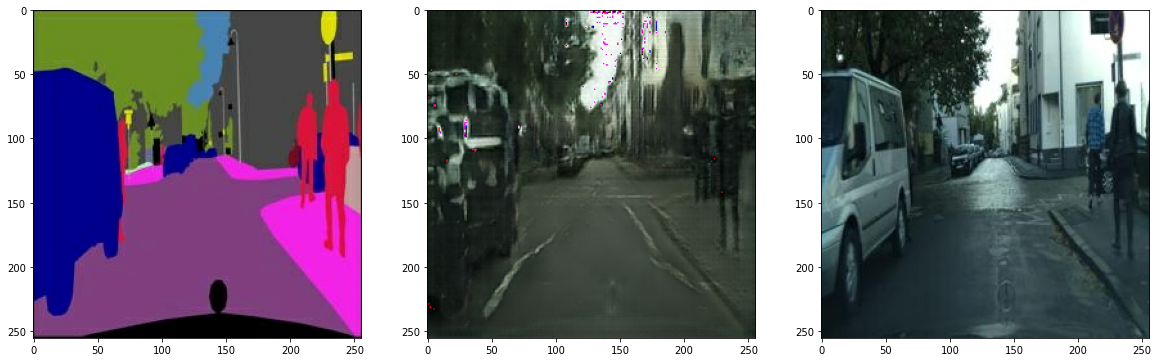

In [22]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

## 7. 끝난 줄 알았죠? 한번 더 해봅시다!

In [23]:
EPOCHS = 10

generator2 = UNetGenerator()
discriminator2 = Discriminator()
history = {'gen_loss2':[], 'l1_loss2':[], 'disc_loss2':[]}

for epoch in range(1, EPOCHS+1):
    for i, (input_image, real_image) in enumerate(train_images):
        g_loss2, l1_loss2, d_loss2 = train_step(input_image, real_image)
        history['gen_loss2'].append(g_loss2)
        history['l1_loss2'].append(l1_loss2)
        history['disc_loss2'].append(d_loss2)
        
        # 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss2.numpy():.4f} \
                    \nL1_loss:{l1_loss2.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss2.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:1.6216                     
L1_loss:0.1522                     
Discriminator_loss:2.2273

EPOCH[1] - STEP[200]                     
Generator_loss:1.2120                     
L1_loss:0.1759                     
Discriminator_loss:1.2387

EPOCH[2] - STEP[100]                     
Generator_loss:1.0779                     
L1_loss:0.2205                     
Discriminator_loss:0.8310

EPOCH[2] - STEP[200]                     
Generator_loss:2.3485                     
L1_loss:0.2118                     
Discriminator_loss:0.1786

EPOCH[3] - STEP[100]                     
Generator_loss:1.3751                     
L1_loss:0.1641                     
Discriminator_loss:1.6747

EPOCH[3] - STEP[200]                     
Generator_loss:1.3619                     
L1_loss:0.2012                     
Discriminator_loss:0.4103

EPOCH[4] - STEP[100]                     
Generator_loss:1.3438                     
L1_loss:0.1983             

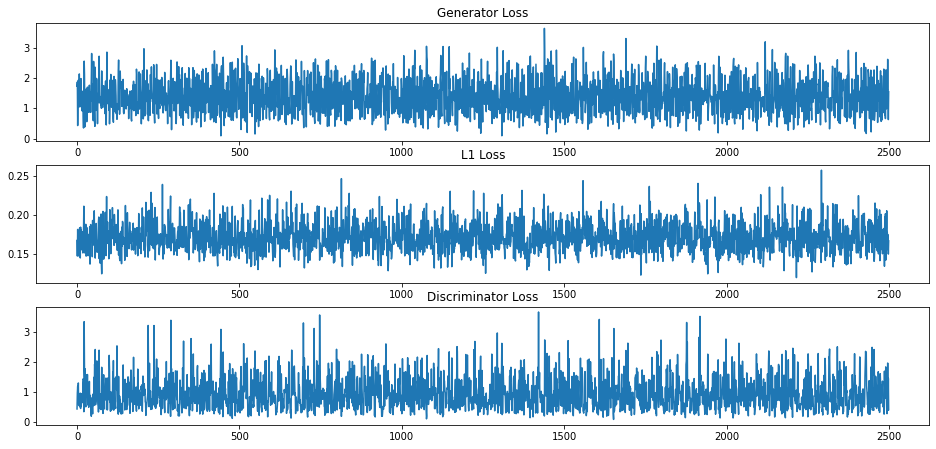

In [24]:
plt.figure(figsize=(16,10))

plt.subplot(411)
plt.plot(history['gen_loss2'])
plt.title('Generator Loss')

plt.subplot(412)
plt.plot(history['l1_loss2'])
plt.title('L1 Loss')

plt.subplot(413)
plt.plot(history['disc_loss2'])
plt.title('Discriminator Loss')

plt.show()

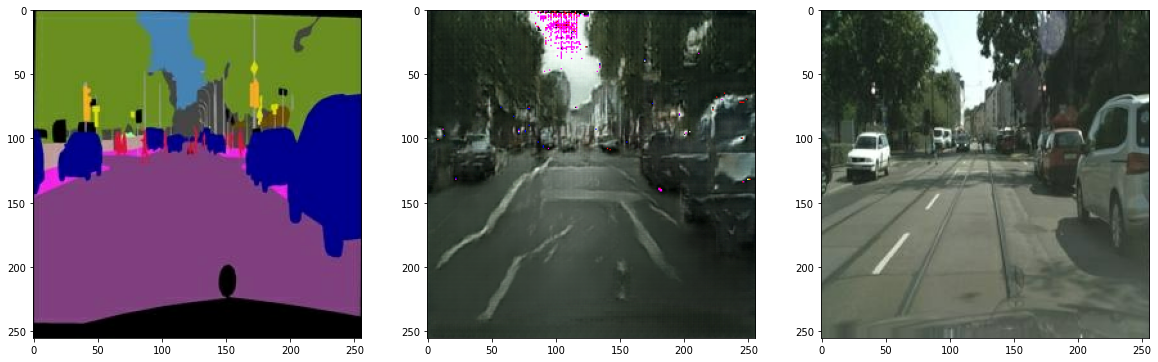

In [26]:
test_ind = 1

f = data_path2 + os.listdir(data_path2)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

- 10 epoch로 줄여 임의의 이미지를 학습시킨 결과는 더욱 안 좋았다.
- 이전에 100 epoch를 시도했던 이미지보다 분홍 픽셀의 노이즈가 훨씬 뚜렷하게 나타났으며, 일그러진 정도도 더 크게 나타났다. 가령 100epoch를 시도한 이미지에서는 사람이 다니는 인도 부분이 그럴듯한 품질을 보여주었지만 10epoch 이미지에서는 인식이 더 어려웠다.
- 출력된 이미지 자체의 품질 또한 100epoch 이미지보다는 좋지 않았다.

## 8. 프로젝트 회고

- 사실 노드에서는 최소 10 epoch 이상으로 수행을 하면 된다고 언급돼 있었지만 100 epoch로 학습을 진행했는데도 매끄러운 결과를 만들어내지는 못한 것을 알 수 있었다. 당장 모델이 예측하여 채색한 도로 이미지를 봐도, **노이즈로 인해 차의 형상이 제대로 그려지지 않았다.** 10epoch 이미지는 더더욱 노이즈가 심했고 전체적으로 이미지에 포함된 객체가 쉽게 인식하기 어려운 모양으로 그려졌다.
- 또한 **loss의 흐름이 전반적으로 들쭉날쭉**하게 나와서 그런지 예측 이미지에 많은 영향을 받지 않았을까 생각해본다.
- 조금 더 시간이 많이 있었더라면 epoch 값을 더 다양하게 주고 학습시켜서 결과를 더 상세하게 시각적으로 비교분석해볼 수 있었을 텐데 그 부분이 아쉽다.
- **(루브릭 1)** 학습 데이터의 다양성 확보를 위해 회전변환을 기반한 Augmentation 방법을 사용하였고 훈련 데이터와 검증 데이터 수 확인, 이미지의 형상 확인, Normalize 등의 분석을 실행하였다.
- **(루브릭 2)** train_step을 각 epoch마다 밟아 끝까지 무사히 잘 출력되었다. 단지 loss 값의 흐름이 들쭉날쭉했을 뿐...
- **(루브릭 3)** 10epoch 이미지와 100epoch 이미지를 간단하게나마 비교분석하여 품질의 우열을 판단하였다.